## Get diagnosis- and subgroup-specific performance

## Imports

In [1]:
import os
import random
import sys
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics
import random
import torch
from os import listdir
from os.path import isfile, join

from cyclops.processors.column_names import EVENT_NAME
from cyclops.utils.file import load_pickle
from models.temporal.optimizer import Optimizer, EarlyStopper
from models.temporal.utils import (
    get_data,
    get_device,
    get_temporal_model,
    load_checkpoint,
)
from models.temporal.metrics import print_metrics_binary
from drift_detection.gemini.utils import prep, get_use_case_params, import_dataset_hospital
from drift_detection.gemini.constants import DIAGNOSIS_DICT, HOSPITALS

In [2]:
DIAGNOSIS_DICT

{'Certain infectious and parasitic diseases': ('A00', 'B99'),
 'Neoplasms': ('C00', 'D49'),
 'Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism': ('D50',
  'D89'),
 'Endocrine, nutritional and metabolic diseases': ('E00', 'E89'),
 'Mental, Behavioral and Neurodevelopmental disorders': ('F01', 'F99'),
 'Diseases of the nervous system': ('G00', 'G99'),
 'Diseases of the eye and adnexa': ('H00', 'H59'),
 'Diseases of the ear and mastoid process': ('H60', 'H95'),
 'Diseases of the circulatory system': ('I00', 'I99'),
 'Diseases of the respiratory system': ('J00', 'J99'),
 'Diseases of the digestive system': ('K00', 'K95'),
 'Diseases of the skin and subcutaneous tissue': ('L00', 'L99'),
 'Diseases of the musculoskeletal system and connective tissue': ('M00',
  'M99'),
 'Diseases of the genitourinary system': ('N00', 'N99'),
 'Pregnancy, childbirth and the puerperium': ('O00', 'O99'),
 'Certain conditions originating in the perinatal period'

In [4]:
DATASET = "gemini"
USE_CASE = "mortality"
ID = "random"
DIR=os.path.join("/mnt/nfs/project/delirium/drift_exp/OCT-18-2022/",DATASET,USE_CASE,"saved_models")
    
use_case_params = get_use_case_params(DATASET, USE_CASE)

In [7]:
output_dim = 1
batch_size = 64
input_dim = 91
timesteps = 6
hidden_dim = 64
layer_dim = 2
dropout = 0.2
learning_rate = 2e-3
weight_decay = 1e-6
last_timestep_only = False
model_name="lstm"
device = get_device()

model_params = {
    "device": device,
    "input_dim": input_dim,
    "hidden_dim": hidden_dim,
    "layer_dim": layer_dim,
    "output_dim": output_dim,
    "dropout_prob": dropout,
    "last_timestep_only": last_timestep_only,
}
model = get_temporal_model(model_name, model_params).to(device)

## Get all diagnosis-specific performance for all-cause models

In [ ]:
reps = list()
for i in range(1, 6):

    filepath=os.path.join(DIR,ID+"_reweight_positive"+"_"+model_name+"_"+str(i)+".pt")
    model = get_temporal_model(model_name, model_params).to(device)
    model, opt, n_epochs = load_checkpoint(filepath, model)

    val = list()
    test = list()
    codes = list()

    for value in list(DIAGNOSIS_DICT.values()) + ['all cause','male','female','adult_18_29','adult_30_44','adult_45_64','geriatric']:
        torch.manual_seed(i)
        random.seed(i)
        
        if value == 'all cause':
            diagnosis_trajectory = 'all cause'
            diagnosis_id = SPLIT
        elif value in ['male','female','adult_18_29','adult_30_44','adult_45_64','geriatric']:
            diagnosis_trajectory = diagnosis_id = value
        else:
            diagnosis_trajectory = value[0]+"_"+value[1]
            diagnosis_id = SPLIT+"_"+ diagnosis_trajectory

        if diagnosis_trajectory in ["H00_H59","H60_H95", "O00_O99", "P00_P96", "Q00_Q99",'V00_Y99']:
            continue


        (X_train, y_train), (X_val, y_val), (X_test, y_test) = import_dataset_hospital(use_case_params.TAB_VEC_COMB, diagnosis_id)

        train_dataset = get_data(X_train, y_train)
        train_loader = train_dataset.to_loader(batch_size, shuffle=True)

        val_dataset = get_data(X_val, y_val)
        val_loader = val_dataset.to_loader(batch_size=1, shuffle=True)

        test_dataset = get_data(X_test, y_test)
        test_loader = test_dataset.to_loader(batch_size=1, shuffle=True)

        y_val_labels, y_val_pred_values, y_val_pred_labels = opt.evaluate(
            train_loader
        )

        y_val_pred_values = y_val_pred_values[y_val_labels != -1]
        y_val_pred_labels = y_val_pred_labels[y_val_labels != -1]
        y_val_labels = y_val_labels[y_val_labels != -1]

        val_pred_metrics = print_metrics_binary(y_val_labels, y_val_pred_values, y_val_pred_labels, verbose=False)

        y_test_labels, y_pred_values, y_pred_labels = opt.evaluate(
            test_loader
        )

        y_pred_values = y_pred_values[y_test_labels != -1]
        y_pred_labels = y_pred_labels[y_test_labels != -1]
        y_test_labels = y_test_labels[y_test_labels != -1]

        test_pred_metrics = print_metrics_binary(y_test_labels, y_pred_values, y_pred_labels, verbose=False)

        val.append(val_pred_metrics)
        test.append(test_pred_metrics)
        codes.append(diagnosis_trajectory)

    val = output = {
        k: [d[k] for d in val if k in d]
        for k in set().union(*val)
    }

    test = output = {
        k: [d[k] for d in test if k in d]
        for k in set().union(*test)
    }

    val_df = pd.DataFrame(val, index=codes).sort_index()
    val_df.to_csv(os.path.join(os.getcwd(),'../output/'+USE_CASE+'_'+ID+'_all_cause_diagnosis_specific_val_results.txt'), sep='\t')
    val_df.rename(index={'':'All-Cause'},inplace=True)

    test_df = pd.DataFrame(test, index=codes).sort_index()
    test_df.to_csv(os.path.join(os.getcwd(),'../output/'+USE_CASE+'_'+ID+'_all_cause_diagnosis_specific_test_results.txt'), sep='\t')
    test_df.rename(index={'':'All-Cause'},inplace=True)

    reps.append(pd.DataFrame(val))

reps = pd.concat(reps,axis=1)
reps['codes'] = codes
reps.to_csv(os.path.join(os.getcwd(),'../output/'+USE_CASE+'_'+MODEL_TYPE+'_diagnosis_specific_results.txt'), sep='\t')

In [5]:
MODEL_TYPE="acute_care"
reps = pd.read_csv(os.path.join(os.getcwd(),'../output/'+USE_CASE+'_'+MODEL_TYPE+'_diagnosis_specific_results.txt'),sep='\t')  
reps.columns = ["Unamed: 0"] + list(reps.columns[1:10])*5 + ["codes"]

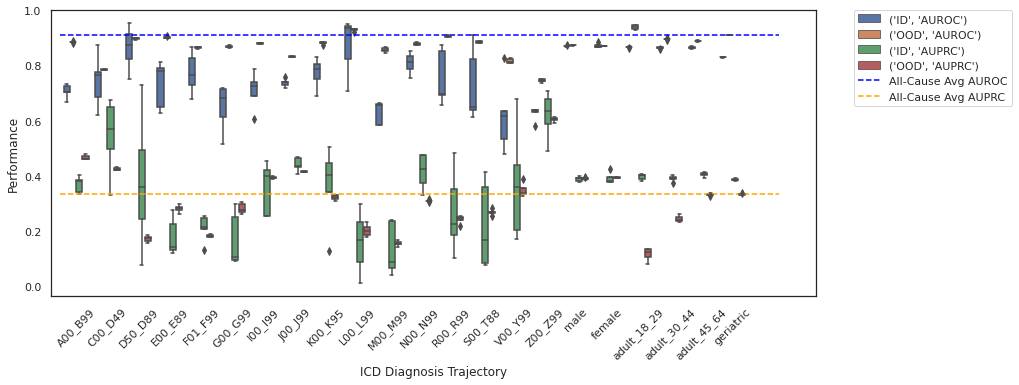

In [14]:
auroc = reps[['auroc','codes','type']]
auroc = pd.melt(auroc.iloc[:, : 7], id_vars=['codes','type'], value_vars=['auroc'])
auprc = reps[['auprc','codes','type']]
auprc = pd.melt(auprc.iloc[:, : 7], id_vars=['codes','type'], value_vars=['auprc'])
plot_metrics = pd.concat([auroc,auprc])
plot_metrics = plot_metrics[plot_metrics.codes != "all cause"]
plot_metrics = plot_metrics.assign(variable=plot_metrics.variable.map({'auroc':'AUROC','auprc':'AUPRC'}))
sns.set(rc={'figure.figsize':(13.7,5.27)})
sns.set(style="darkgrid")
sns.set_style(style='white')
sns.boxplot(x = 'codes', y = 'value', hue = plot_metrics[['type', 'variable']].apply(tuple, axis=1), data = plot_metrics,).set(
    xlabel="ICD Diagnosis Trajectory", 
    ylabel="Performance"
)
plt.xticks(rotation=45)
allcause_auroc = reps[['auroc']].iloc[[-1]].mean(axis=1)
allcause_auprc = reps[['auprc']].iloc[[-1]].mean(axis=1)
plt.plot([-0.5, 22.5], [allcause_auroc, allcause_auroc],'--', label='All-Cause Avg AUROC', color='blue')
plt.plot([-0.5, 22.5], [allcause_auprc, allcause_auprc],'--', label='All-Cause Avg AUPRC', color='orange')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [15]:
all_datasets = list()
avg_allcause = list()
for MODEL_TYPE in ["day","hosp_type_community","acute_care","not_acute_care","not_nursing_home"]:
    reps = pd.read_csv(os.path.join(os.getcwd(),'../output/'+USE_CASE+'_'+MODEL_TYPE+'_diagnosis_specific_results.txt'),sep='\t')  
    reps.columns = ["Unamed: 0"] + list(reps.columns[1:10])*5 + ["codes"]
    auroc = reps[['auroc','codes','type']]
    auroc = pd.melt(auroc.iloc[:, : 7], id_vars=['codes','type'], value_vars=['auroc'])
    auroc['dataset'] = MODEL_TYPE
    all_datasets.append(auroc)
    avg_allcause.append(reps[['auroc']].iloc[[-1]].mean(axis=1))
plot_metrics = pd.concat(all_datasets)

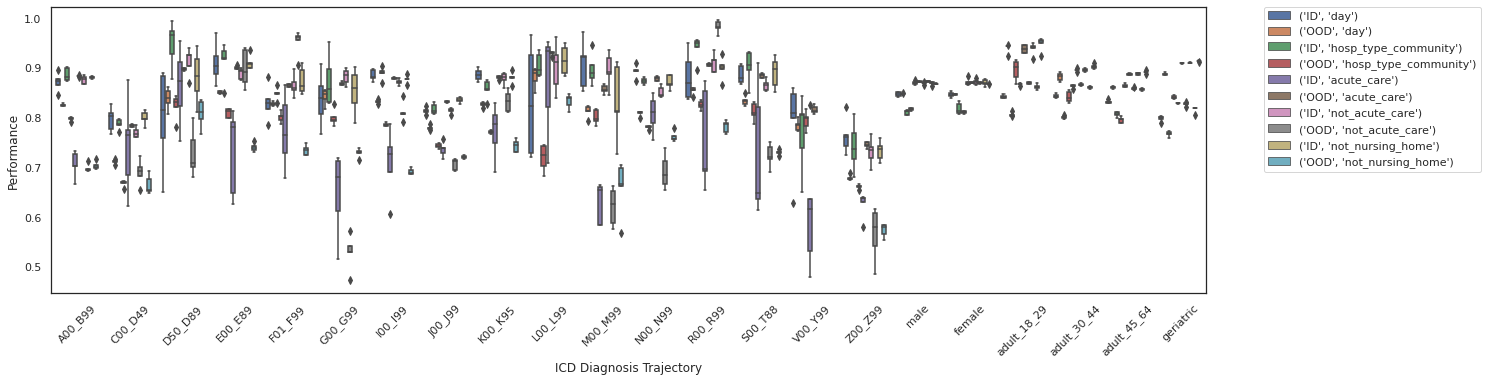

In [16]:
plot_metrics = plot_metrics[plot_metrics.codes != "all cause"]
plot_metrics = plot_metrics.assign(variable=plot_metrics.variable.map({'auroc':'AUROC'}))
plot_metrics.to_csv(os.path.join(os.getcwd(),'../output/'+USE_CASE+'_all_diagnosis_specific_results.txt'), sep='\t')

sns.set(rc={'figure.figsize':(20.7,5.27)})
sns.set(style="darkgrid")
sns.set_style(style='white')
sns.boxplot(x = 'codes', y = 'value', hue = plot_metrics[['type', 'dataset']].apply(tuple, axis=1), data = plot_metrics,).set(
    xlabel="ICD Diagnosis Trajectory", 
    ylabel="Performance"
)
plt.xticks(rotation=45)
#plt.plot([-0.5, 22.5], [avg_allcause[0], avg_allcause[0]],'--', label='All-Cause Avg AUROC', color='blue')
#plt.plot([-0.5, 22.5], [avg_allcause[1], avg_allcause[1]],'--', label='All-Cause Avg AUROC', color='orange')
#plt.plot([-0.5, 22.5], [avg_allcause[2], avg_allcause[2]],'--', label='All-Cause Avg AUROC', color='green')
#plt.plot([-0.5, 22.5], [avg_allcause[3], avg_allcause[3]],'--', label='All-Cause Avg AUROC', color='red')
#plt.plot([-0.5, 22.5], [avg_allcause[4], avg_allcause[4]],'--', label='All-Cause Avg AUROC', color='purple')
#plt.plot([-0.5, 22.5], [avg_allcause[5], avg_allcause[5]],'--', label='All-Cause Avg AUROC', color='brown')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)